In [1]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemFD, GlobalEM1DSurveyFD, get_vertical_discretization_frequency
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import empymod

# Seting up a 2D mesh and model

In [3]:
frequency = np.array([25., 100., 382, 1822, 7970, 35920], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=0.1, n_layer=30)

In [4]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

In [5]:
n_sounding = 50
dx = 100.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
sigma = np.ones(mesh.nC) * 1./20.
sigma[inds] = 1./30.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 75.]
x2 = np.r_[dx*n_sounding, 90.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 1./50
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()
chi = np.zeros_like(sigma_em1d)
# chi[poly_inds] = 0.005

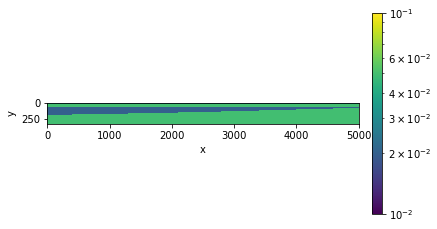

In [6]:
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=False, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [7]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

In [8]:
mapping = Maps.ExpMap(mesh)
# mapping = Maps.IdentityMap(mesh)
survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 7.86,
    src_type = "VMD",
    rx_type = "ppm",
    field_type = 'secondary',
    topo = topo
)
prob = GlobalEM1DProblemFD(
    mesh, sigmaMap=mapping, chi=chi, hz=hz, parallel=True, n_cpu=2, verbose=True,
    Solver=PardisoSolver
)
prob.pair(survey)
m = np.log(sigma_em1d)
# m =  sigma_em1d.copy()
prob.model = m

>> Use multiprocessing for parallelization
>> n_cpu: 2


In [9]:
# %%time
dobs = survey.makeSyntheticData(m, std=0.03, force=True)

Compute fields
>> Compute response
SimPEG.Survey assigned new std of 3.00%


Text(0, 0.5, 'Hz/Hp (ppm)')

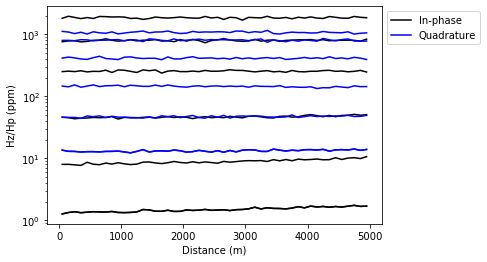

In [10]:
DOBS = dobs.reshape(( prob.n_sounding, 2, survey.n_frequency))
i_freq=0
plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'b')    
plt.legend(("In-phase", "Quadrature"), bbox_to_anchor=(1,1))
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'b')    
plt.xlabel("Distance (m)")
plt.ylabel("Hz/Hp (ppm)")

In [11]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)
from simpegEM1D import get_2d_mesh, LateralConstraint

In [12]:
def run_inversion(option=None, ps=2, px=2, pz=2, alpha_s=1., alpha_x=1., alpha_z=1.):
    
    mapping = Maps.ExpMap(mesh)
    # mapping = Maps.IdentityMap(mesh)
    survey = GlobalEM1DSurveyFD(
        rx_locations = rx_locations,
        src_locations = src_locations,    
        frequency = frequency,
        offset = np.ones_like(frequency) * 7.86,
        src_type = "VMD",
        rx_type = "ppm",
        field_type = 'secondary',
        topo = topo
    )
    survey.dobs = dobs
    prob = GlobalEM1DProblemFD(
        mesh, sigmaMap=mapping, chi=chi, hz=hz, parallel=True, n_cpu=2, verbose=True,
        Solver=PardisoSolver
    )
    prob.pair(survey)
#     m = np.log(sigma_em1d)

    mesh_reg = get_2d_mesh(n_sounding, hz)
    regmap = Maps.IdentityMap(mesh_reg)
    # mapping is required ... for IRLS
    reg = LateralConstraint(
        mesh_reg, mapping=regmap,
        alpha_s = alpha_s,
        alpha_x = alpha_x,
        alpha_y = alpha_z,
    )
    xy = Utils.ndgrid(np.arange(n_sounding), np.r_[0.])
    reg.get_grad_horizontal(xy, hz, dim=2, use_cell_weights=True)
    std = 0.03
    floor = 0.
    np.random.seed(1)
    uncert = std*abs(dobs)+floor
    m0 = np.ones(mesh_reg.nC) * np.log(1./20.)
#     m0 = np.ones(mesh_reg.nC) *1./20.
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    dmisfit.W = 1./uncert
    ps = ps
    px, pz = px, pz
    reg.norms = np.c_[ps, px, pz, 0.]
    IRLS = Directives.Update_IRLS(
        maxIRLSiter=30, minGNiter=1, 
        fix_Jmatrix=True, 
        betaSearch=True,
        f_min_change = 1e-4,
        coolingRate=3
    )
    opt = Optimization.InexactGaussNewton(maxIter = 40, maxIterCG=20)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
    target = Directives.TargetMisfit()
    sense = Directives.UpdateSensitivityWeights()
    update_precon = Directives.UpdatePreconditioner()
    if option is None:
        reg.alpha_x=0.
        inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target, sense])        
    elif option == "l2":
        reg.alpha_x=10.        
        inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, sense])
    elif option == "l0":
        inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest, sense])
    prob.counter = opt.counter = Utils.Counter()
    opt.LSshorten = 0.5
    opt.remember('xc')
#     print (reg.cell_weights)
    mopt = inv.run(m0) 
    if option == 'l0':
        return mopt, invProb.l2model, invProb.dpred
    else:
        return mopt, invProb.dpred

In [13]:
# mopt_none, pred = run_inversion(option=None)

In [14]:
# mopt_l2, pred = run_inversion(option='l2')

In [15]:
mopt_l0_ps0, mopt_l2_ps0, pred = run_inversion(option='l0', ps=0, px=2, pz=2, alpha_s=1., alpha_x=10., alpha_z=1.)

>> Use multiprocessing for parallelization
>> n_cpu: 2
SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:935: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


Compute fields
>> Compute response
>> Compute J sigma
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.03e+00  2.57e+04  0.00e+00  2.57e+04    6.27e+03      0              
Compute fields
>> Compute response
>> Compute J sigma
   1  6.03e+00  1.29e+03  1.72e+01  1.40e+03    6.82e+02      0              
Compute fields
>> Compute response
>> Compute J sigma
   2  6.03e+00  3.07e+02  2.45e+01  4.54e+02    1.65e+02      0   Skip BFGS  
Compute fields
>> Compute response
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.6342385711563501 eps_q: 0.6342385711563501
>> Fix Jmatrix
delta phim:    inf
>> Compute J sigma
   3  3.02e+00  2.18e+02  4.20e+01  3.44e+02    7.06e+01      0   Skip BFGS  
Compute fields
>> Compute response
Bet

In [16]:
mopt_l0_qx2, mopt_l2_qx2, pred = run_inversion(option='l0', ps=2, px=2, pz=0, alpha_s=1e-2, alpha_x=10., alpha_z=1.)

>> Use multiprocessing for parallelization
>> n_cpu: 2
SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Compute fields
>> Compute response


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:935: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


>> Compute J sigma
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.15e+00  2.57e+04  0.00e+00  2.57e+04    6.27e+03      0              
Compute fields
>> Compute response
>> Compute J sigma
   1  7.15e+00  1.59e+03  2.63e-01  1.59e+03    8.19e+02      0              
Compute fields
>> Compute response
>> Compute J sigma
   2  7.15e+00  3.19e+02  2.10e+00  3.35e+02    2.30e+02      0   Skip BFGS  
Compute fields
>> Compute response
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.7908770648777925 eps_q: 0.7908770648777925
>> Fix Jmatrix
delta phim:    inf
>> Compute J sigma
   3  3.57e+00  2.17e+02  3.03e+00  2.28e+02    1.03e+02      0   Skip BFGS  
Compute fields
>> Compute response
Beta search step
Compute fields
>> Com

In [17]:
mopt_l0, mopt_l2, pred = run_inversion(option='l0', ps=2, px=0, pz=0, alpha_s=1e-2, alpha_x=10., alpha_z=1.)

>> Use multiprocessing for parallelization
>> n_cpu: 2
SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Compute fields
>> Compute response


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:935: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


>> Compute J sigma
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.15e+00  2.57e+04  0.00e+00  2.57e+04    6.27e+03      0              
Compute fields
>> Compute response
>> Compute J sigma
   1  7.15e+00  1.59e+03  2.63e-01  1.59e+03    8.19e+02      0              
Compute fields
>> Compute response
>> Compute J sigma
   2  7.15e+00  3.20e+02  2.10e+00  3.35e+02    2.31e+02      0   Skip BFGS  
Compute fields
>> Compute response
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.7905642935391772 eps_q: 0.7905642935391772
>> Fix Jmatrix
delta phim:    inf
>> Compute J sigma
   3  3.57e+00  2.13e+02  1.68e+00  2.19e+02    8.81e+01      0   Skip BFGS  
Compute fields
>> Compute response
Beta search step
Compute fields
>> Com

Compute fields
>> Compute response
>> Fix Jmatrix
Reach maximum number of IRLS cycles: 30
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.5682e+03
1 : |xc-x_last| = 1.7725e-01 <= tolX*(1+|x0|) = 1.1702e+01
0 : |proj(x-g)-x|    = 3.6919e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.6919e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      40    <= iter          =     33
------------------------- DONE! -------------------------


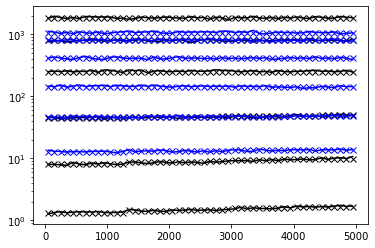

In [18]:
DOBS = dobs.reshape((prob.n_sounding, 2, survey.n_frequency))
DPRED = pred.reshape((prob.n_sounding, 2, survey.n_frequency))
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
    plt.semilogy(mesh.vectorCCx, DPRED[:,0,i_freq], 'kx')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'b')
    plt.semilogy(mesh.vectorCCx, DPRED[:,1,i_freq], 'bx')

In [19]:
sigma_est_l2 = Utils.mkvc((np.exp(mopt_l2)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l2_qx2 = Utils.mkvc((np.exp(mopt_l2_qx2)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l2_ps0 = Utils.mkvc((np.exp(mopt_l2_ps0)).reshape((prob.n_sounding, prob.n_layer)))

sigma_est_l0 = Utils.mkvc((np.exp(mopt_l0)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l0_qx2 = Utils.mkvc((np.exp(mopt_l0_qx2)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l0_ps0 = Utils.mkvc((np.exp(mopt_l0_ps0)).reshape((prob.n_sounding, prob.n_layer)))

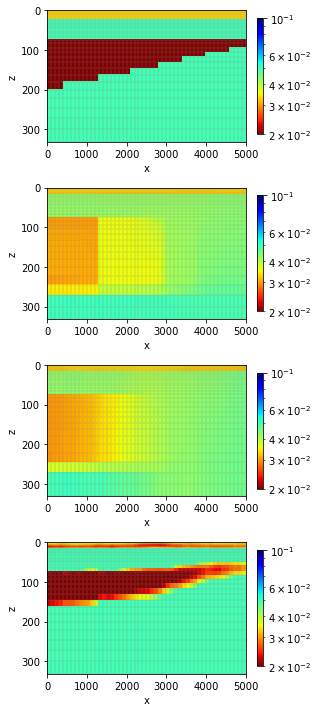

In [20]:
sigmas = [
    sigma, 
    sigma_est_l0,
    sigma_est_l0_qx2,
    sigma_est_l0_ps0
]
fig, axs = plt.subplots(4,1, figsize=(5, 10))
for ii in range(4):
    cb = plt.colorbar(
        mesh.plotImage(
            sigmas[ii], grid=True, clim=(1./50, 1e-1), ax=axs[ii], 
            pcolorOpts={"norm":LogNorm(), 'cmap': 'jet_r'},
            gridOpts={'alpha':0.2, 'color':'grey'}
        )[0],
        fraction=0.02, pad=0.04, ax=axs[ii]
    )
    axs[ii].set_ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
    axs[ii].set_ylabel("z")
    axs[ii].set_ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
    axs[ii].set_aspect(10)
plt.tight_layout()

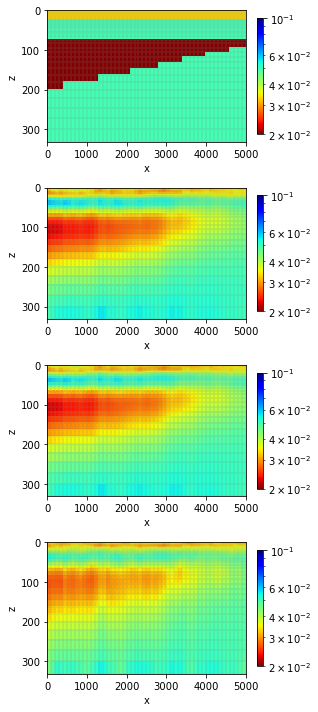

In [21]:
sigmas = [
    sigma, 
    sigma_est_l2,
    sigma_est_l2_qx2,
    sigma_est_l2_ps0
]
fig, axs = plt.subplots(4,1, figsize=(5, 10))
for ii in range(4):
    cb = plt.colorbar(
        mesh.plotImage(
            sigmas[ii], grid=True, clim=(1./50, 1e-1), ax=axs[ii], 
            pcolorOpts={"norm":LogNorm(), 'cmap': 'jet_r'},
            gridOpts={'alpha':0.2, 'color':'grey'}
        )[0],
        fraction=0.02, pad=0.04, ax=axs[ii]
    )
    axs[ii].set_ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
    axs[ii].set_ylabel("z")
    axs[ii].set_ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
    axs[ii].set_aspect(10)
plt.tight_layout()